In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sympy as sp

from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.optimize import approx_fprime

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

import iqbal_agn_heating_functions as iq
from cluster_measurements import ClusterMeasurements

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# model consts
h70=1
P0=6.85
c500=1.09
gamma=0.31
alpha=1.07
beta=5.46

gamma_b=4./3.

In [5]:
def E(z): #ratio of the Hubble constant at redshift z to its present value
    return cosmo.H(z)/cosmo.H(0)

In [6]:
def P500(z, M500):
    M500=M500.to(u.Msun)
    return ((1.65*1e-3*E(z)**(8/3)
            *(M500/(3*1e14*h70**(-1)*u.Msun))**2/3 
            *h70**2 * u.keV * u.cm**-3)).to(u.erg/u.cm**3, equivalencies=u.mass_energy()) 

In [7]:
def Pg(x, z, M500): #x=r/r500
    #print(x)
    return (P0*P500(z, M500) #units keVcm-3
           / ((c500*x)**gamma  #unitless
              * (1+ (c500*x)**alpha)**((beta-gamma)/alpha))).to(u.erg/u.cm**3, equivalencies=u.mass_energy())

def Pg_r(r, z, M500, R500):
    return Pg(r/R500, z, M500).value

In [8]:
P500(z, M500)

NameError: name 'z' is not defined

In [2]:
x=np.logspace(-2, 1)
z=0, 
M500=6*1e14*u.Msun
plt.loglog(x, Pg(x, z, M500).to(u.erg*u.cm**-3))
plt.xlabel('r/r500')
plt.ylabel('Pg (erg/cm3)')
plt.xlim(0.02, 3)
plt.ylim( 7*1e-15, 5*1e-10)

NameError: name 'Pg' is not defined

[array(-4.95429617e-09),
 array(-4.16998034e-09),
 array(-3.51523248e-09),
 array(-2.96818875e-09),
 array(-2.51066485e-09),
 array(-2.12753606e-09),
 array(-1.80622247e-09),
 array(-1.53626116e-09),
 array(-1.30895133e-09),
 array(-1.11705975e-09),
 array(-9.54576721e-10),
 array(-8.16514006e-10),
 array(-6.98737686e-10),
 array(-5.97830061e-10),
 array(-5.10975503e-10),
 array(-4.35865972e-10),
 array(-3.70622386e-10),
 array(-3.13728447e-10),
 array(-2.6397395e-10),
 array(-2.20404872e-10),
 array(-1.82278034e-10),
 array(-1.49018544e-10),
 array(-1.20179116e-10),
 array(-9.54011061e-11),
 array(-7.43781967e-11),
 array(-5.68245363e-11),
 array(-4.24496434e-11),
 array(-3.0942373e-11),
 array(-2.19652927e-11),
 array(-1.51593636e-11),
 array(-1.01568928e-11),
 array(-6.59920512e-12),
 array(-4.15474545e-12),
 array(-2.53371061e-12),
 array(-1.49670865e-12),
 array(-8.56760355e-13),
 array(-4.75612063e-13),
 array(-2.56322039e-13),
 array(-1.34290088e-13),
 array(-6.85023073e-14),
 a

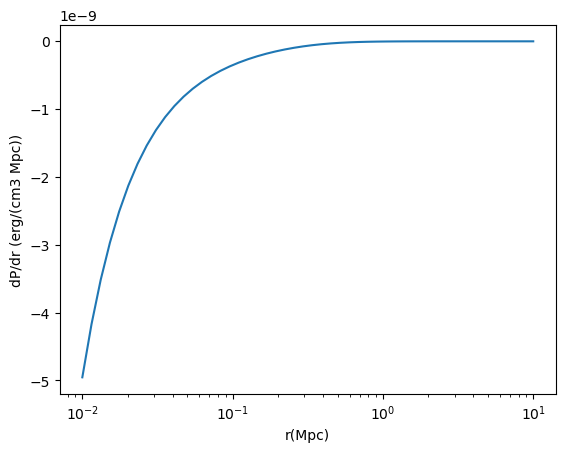

In [66]:
#r=np.logspace(-2, 1)*R500
x_vals=np.logspace(-2, 1)
rs=x_vals*R500
plt.plot(rs, [dP_dr(r, R500, M500, z) for r in rs])
plt.xlabel('r(Mpc)')
plt.ylabel('dP/dr (erg/(cm3 Mpc))')
plt.xscale('log')
#plt.yscale('symlog')
[dP_dr(r, R500, M500, z) for r in rs]


In [67]:
def dP_dr(r, R500, M500, z):
    if isinstance(R500, u.Quantity):
        R500=R500.to(u.Mpc).value
    gradients=approx_fprime(r, lambda r: Pg_r(r, z, M500, R500))[0]*u.erg/(u.cm**3 * u.Mpc)
    #print(gradients)
    return np.array(gradients)#*u.erg/(u.cm**3 * u.Mpc)
    #return gradients
    
def integrand(r, R500, M500, z, r0, rc):
    r=r*u.Mpc
    x=r/R500
    integrand=(((Pg(x, z, M500))**((gamma_b-1)/gamma_b)).to(u.erg**(1/4)*u.cm**(-3/4))
               *(1/Pg(x, z, M500)).to(u.cm**3/u.erg) 
               #*np.array([dP_dr([rad.value], R500, M500, z).to(u.erg*u.cm**(-3)*u.Mpc**(-1)) for rad in rs]) 
               *dP_dr(r.value, R500, M500, z)*(u.erg/(u.cm**3 * u.Mpc))
               *(1-np.exp(-1*r/r0)).to(1)
               *(np.exp(-1*r/rc)).to(1))
    #print(integrand)
    return integrand.to(u.erg**(1/4) * u.cm**(-3/4) *u.Mpc**(-1)).value
    
def q(R500, M500, z, r0, rc):
    rini=0.015*R500.to(u.Mpc).value
    rmax=R500.to(u.Mpc).value
    integral, _ = quad(integrand, rini, rmax, args=(R500, M500, z, r0, rc))
    return integral*(u.erg**(1/4) * u.cm**(-3/4))

In [68]:
def h(Linj, r, r0, rc, q):
    return (Linj/(4*np.pi*r**2)
            *(1-np.exp(-1*r/r0))
            *np.exp(-1*r/rc)
            *(1/q))

In [69]:
def vol_heating_rate(r, R500, M500, z, Linj, rc):
    x=r/R500
    r0=(0.015*R500).to(u.cm)
    return (h(Linj, r, r0, rc, q(R500, M500, z, r0, rc))
        *((Pg(x, z, M500))**((gamma_b-1)/gamma_b)).to(u.erg**(1/4)/u.cm**(3/4))
        *(1/r).to(1/u.Mpc)
        *(r/Pg(x, z, M500)).to(u.Mpc/(u.erg/u.cm**3))  
        *dP_dr([r.to(u.Mpc).value], R500, M500, z)).to(u.erg/(u.s*u.cm**3)) 

In [2]:
R500=1*u.Mpc
M500=2*1e14*u.Msun/1.25 # virial radius is 2*10^14 Msun=1.25*M500
z=0
rc=0.1*R500#.to(u.cm)
Linj=7*1e44*u.erg/u.s
#rini=0.015*R500.to(u.Mpc).value
#rmax=R500.to(u.Mpc).value
rmax = iq.virial_radius(M500*1.25, z).to(u.Mpc)

x_vals=np.logspace(-2, 1)
rs=x_vals*R500

measurements=ClusterMeasurements(R500, M500, z)

In [26]:
iq.scale_radius(1.25*M500, z)

<Quantity 0.28829734 Mpc>

In [27]:
iq.M_enc(iq.virial_radius(6*1e14*u.Msun, z), measurements2)

<Quantity 6.e+14 solMass>

In [28]:
iq.virial_radius(6*1e14 * u.Msun, z)

<Quantity 2.18375367 Mpc>

(1, 15)

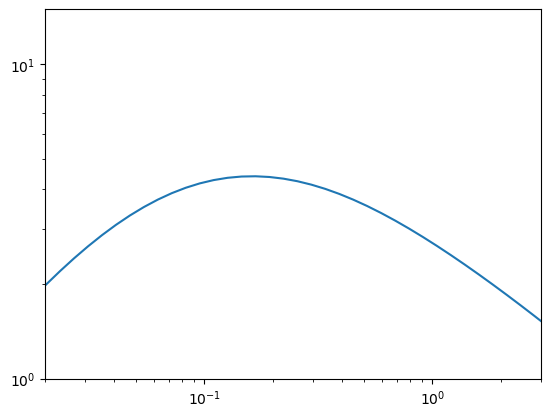

In [34]:
measurements2 = ClusterMeasurements(R500, 6*1e14/1.25 * u.Msun, z)
plt.loglog(rs, iq.T_g(rs.value, measurements2).to(u.keV))
plt.xlim(2*1e-2, 3*1e0)
plt.ylim(1, 15)

(8e-15, 5e-10)

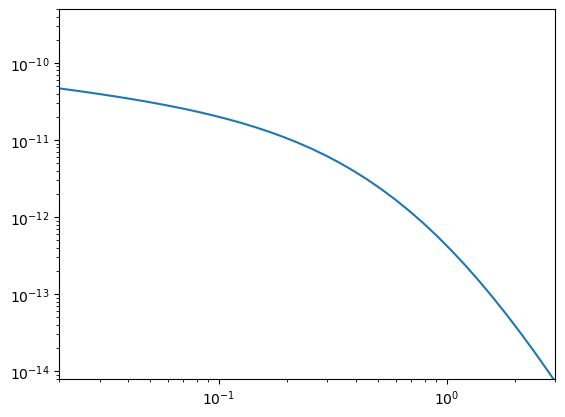

In [41]:
plt.loglog(rs/measurements.R500, iq.Pg(rs/measurements.R500, measurements2))
plt.xlim(2*1e-2, 3*1e0)
plt.ylim(8*1e-15, 5*1e-10)

In [40]:
iq.E(measurements.z)

<Quantity 1.>

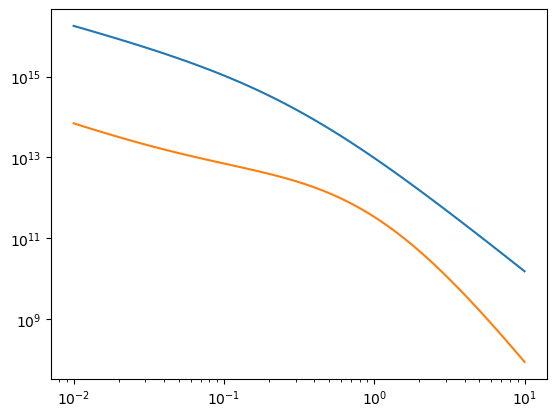

In [42]:
plt.loglog(rs, iq.rho_nfw(rs, measurements))
plt.loglog(rs, iq.rho_g(rs, measurements))

In [4]:
#n_e = 3*(M500/const.m_p).to(1) /(4*np.pi*R500**3)  

n_e = ((iq.rho_g(rs, measurements)/const.m_p)*np.sqrt(0.704)).to(u.Mpc**(-3))
#n_e = ((iq.rho_g(rs, measurements)/const.m_p)*0.704).to(u.Mpc**(-3))
cooling = iq.vol_cooling_rate(n_e, iq.T_g(rs.value, measurements))
#iq.T_g(rs.value, measurements)
cooling

<Quantity [6.50219111e-29, 4.71676641e-29, 3.45102045e-29, 2.54565062e-29,
           1.89269292e-29, 1.41811417e-29, 1.07061500e-29, 8.14316806e-30,
           6.23917440e-30, 4.81440196e-30, 3.74026573e-30, 2.92422092e-30,
           2.29928082e-30, 1.81670215e-30, 1.44084468e-30, 1.14553622e-30,
           9.11486954e-31, 7.24439254e-31, 5.73835080e-31, 4.51847656e-31,
           3.52669529e-31, 2.71980363e-31, 2.06541409e-31, 1.53880767e-31,
           1.12047662e-31, 7.94243880e-32, 5.45915549e-32, 3.62449229e-32,
           2.31600767e-32, 1.41960798e-32, 8.32322591e-33, 4.65704283e-33,
           2.48258894e-33, 1.25969071e-33, 6.08272704e-34, 2.79667030e-34,
           1.22584250e-34, 5.13219670e-35, 2.05740091e-35, 7.92060676e-36,
           2.93804139e-36, 1.05382048e-36, 3.66862124e-37, 1.24426557e-37,
           4.12700431e-38, 1.34358356e-38, 4.30853161e-39, 1.36540762e-39,
           4.28926456e-40, 1.33930412e-40] erg / (cm3 s)>

In [10]:
radiative_cooling_rate(
        (iq.T_g(rs.value, measurements), 
        measurements, 
        n_e)/measurements.volume).to(u.erg/u.s * u.cm**-3)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [13]:
from equilibrium_functions import radiative_cooling_rate
radiative_cooling_rate(
        (iq.T_g(rs.value, measurements), 
        measurements, 
        n_e)/measurements.volume).to(u.erg/u.s * u.cm**-3)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

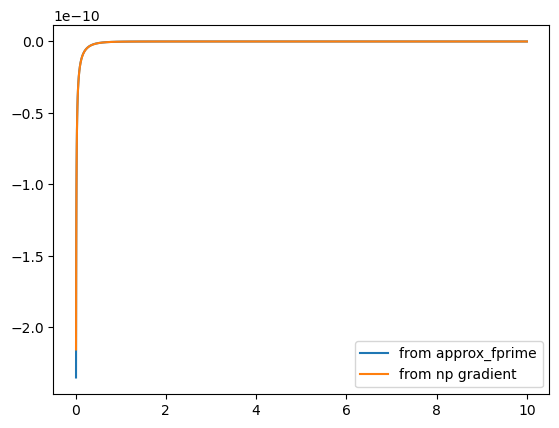

In [77]:
plt.plot(rs, iq.dP_dr(rs, measurements), label="from approx_fprime")
plt.plot(rs,np.gradient(iq.Pg(rs/measurements.R500, measurements), rs), label="from np gradient" )
#plt.plot(rs, iq.Pg(rs/measurements.R500, measurements))
#plt.xscale('log')
#plt.yscale('symlog')
plt.legend()



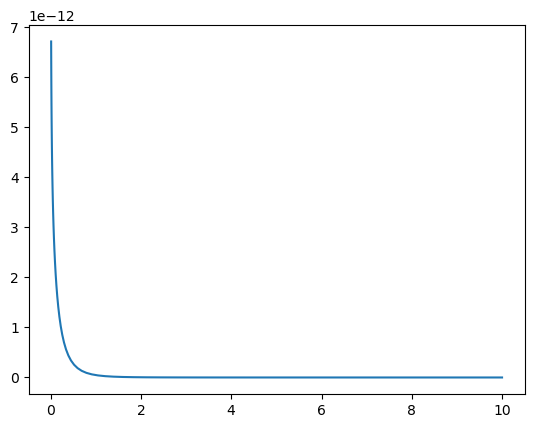

In [78]:
plt.plot(rs, iq.Pg(rs/measurements.R500, measurements))

In [44]:
eps_01=iq.vol_heating_rate(rs, measurements, Linj, rc)

In [45]:
eps_03=iq.vol_heating_rate(rs, measurements, Linj, 3*rc)

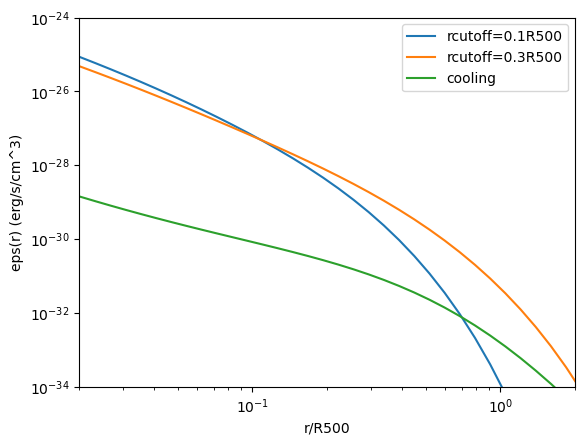

In [46]:
x_vals=np.logspace(-2, 1)
rs=x_vals*R500
plt.loglog(x_vals, eps_01, label='rcutoff=0.1R500')
plt.loglog(x_vals, eps_03, label='rcutoff=0.3R500')
plt.loglog(x_vals, cooling, label='cooling')
plt.xlabel('r/R500')
plt.ylabel('eps(r) (erg/s/cm^3)')
plt.xlim(2*1e-2, 2*1e0)
plt.ylim(1e-34, 1e-24)
plt.legend()

In [44]:
plt.loglog(x_vals, eps_03*R500**3*4*np.pi, label='rcutoff=0.1R500')
#plt.scatter(10, 2*)

NameError: name 'eps_03' is not defined

In [45]:
vhr=eps_03[25]
(vhr*R500**3).to(u.erg/u.s)

NameError: name 'eps_03' is not defined

In [46]:
vhr=eps_03[33]
(vhr*R500**3).to(u.erg/u.s)

NameError: name 'eps_03' is not defined

In [102]:
def rho_g(r, R500, M500, z): # density profile of the baryons in the ICM
    #print([dP_dr(r0, R500, M500, z) for r0 in r])
    dPdr=[dP_dr(r0, R500, M500, z) for r0 in r]
    return (-1*(r**2/(const.G*M_enc(r, R500, M500, z)))*(dPdr)*const.c**2*u.erg/(u.cm**3 * u.Mpc)).to(u.Msun/u.Mpc**3, equivalencies=u.mass_energy())

In [48]:
def calculate_density_normalization(r_s, M500, R500):
    y=R500/r_s
    return ((M500/(4*np.pi*r_s**3))*(np.log(1+y) - y/(1+y))**(-1)).to(u.Msun/u.Mpc**3)

In [49]:
def rho_nfw(r, M500, R500): # input r as scalar in Mpc
    #r_s = 0.005 * u.Mpc
    r_s = iq.scale_radius(1.25*M500, z)
    rho_s = calculate_density_normalization(r_s, M500, R500)#10**18 * u.Msun/(u.Mpc)**3
    r_s = r_s.value
    y=r/r_s
    return(rho_s/(y*(1+y)**2)).to(u.Msun/u.Mpc**3)

def M_tot(rs, R500, M500):
    M = []
    for r in rs:
        r=r.value
        integrand = lambda x: 4*np.pi*x**2 * rho_nfw(x, M500, R500).value 
        M.append(quad(integrand, 0, r)[0])
    return M*u.Msun
    

In [100]:
def M_enc(r, R500, M500, z): #mass enclosed within radius r of an NFW profile
    # pick scale density and radius (TODO: pick these better)
    #r_s = 0.005 * u.Mpc
    r_s = iq.scale_radius(1.25*M500, z)
    rho_s = calculate_density_normalization(r_s, M500, R500)#10**18 * u.Msun/(u.Mpc)**3
    #r_s = r_s.value
    
    y = r/r_s
    return ((4 * np.pi * r_s**3 * rho_s) * (np.log(1+y) - (y/(1+y)))).to(u.Msun)

In [51]:
def T_g(r, R500, M500, z):
    r=r*u.Mpc
    mu=1
    return (mu*const.m_p*Pg(r/R500, z, M500)/rho_g(r, R500, M500, z)).to(u.GeV)

In [52]:
def dT_dr(r, R500, M500, z): #BROKEN
    #R500=R500.to(u.Mpc).value
    #gradients=approx_fprime(r, lambda r: T_g(r, R500, M500,z).value)*u.GeV/(u.Mpc)
    #print(gradients)
    
    np.gradient()
    #return np.array(gradients)#*u.erg/(u.cm**3 * u.Mpc)
    #return gradients

In [53]:
# test cluster
R500=1*u.Mpc
M500=2e14*u.Msun
z=0

x_vals=np.logspace(-2, 1)
rs=x_vals*R500


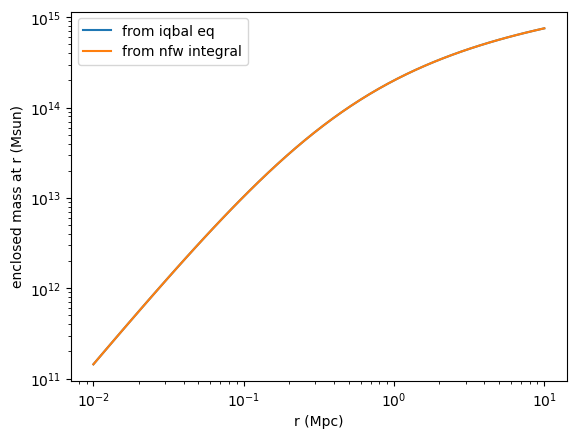

In [54]:
plt.loglog(rs, M_enc(rs, R500, M500), label='from iqbal eq')
plt.loglog(rs, M_tot(rs, R500, M500), label='from nfw integral')
plt.xlabel('r (Mpc)')
plt.ylabel('enclosed mass at r (Msun)')
plt.legend()

In [55]:
M_enc(rs, R500, M500)

<Quantity [1.43971220e+11, 1.89686345e+11, 2.49691339e+11, 3.28339257e+11,
           4.31252826e+11, 5.65667360e+11, 7.40853217e+11, 9.68630137e+11,
           1.26398474e+12, 1.64579966e+12, 2.13769737e+12, 2.76899321e+12,
           3.57573950e+12, 4.60182529e+12, 5.90007516e+12, 7.53326553e+12,
           9.57495109e+12, 1.21099715e+13, 1.52344929e+13, 1.90554403e+13,
           2.36891938e+13, 2.92594719e+13, 3.58943890e+13, 4.37227694e+13,
           5.28698957e+13, 6.34529609e+13, 7.55765616e+13, 8.93285924e+13,
           1.04776880e+14, 1.21966826e+14, 1.40920220e+14, 1.61635264e+14,
           1.84087721e+14, 2.08233019e+14, 2.34009057e+14, 2.61339446e+14,
           2.90136929e+14, 3.20306735e+14, 3.51749712e+14, 3.84365090e+14,
           4.18052818e+14, 4.52715457e+14, 4.88259619e+14, 5.24597010e+14,
           5.61645105e+14, 5.99327537e+14, 6.37574231e+14, 6.76321356e+14,
           7.15511137e+14, 7.55091562e+14] solMass>

In [56]:
plt.plot(rs, [dP_dr(r, R500, M500, z) for r in rs])
#plt.plot(rs, dP_dr(rs, R500, M500, z))
plt.xlabel('r (Mpc)')
plt.ylabel('dP_dr')
plt.yscale('symlog')
plt.xscale('log')

NameError: name 'dP_dr' is not defined

In [57]:

plt.loglog(rs, rho_g(rs, R500, M500, z), label='rho_b')
plt.loglog(rs, rho_nfw(rs.value, M500, R500), label='rho_tot')
plt.xlabel('r (Mpc)')
plt.ylabel('Density of baryon gas (Msun/Mpc**3)')
plt.legend()

NameError: name 'dP_dr' is not defined

(0.01, 4)

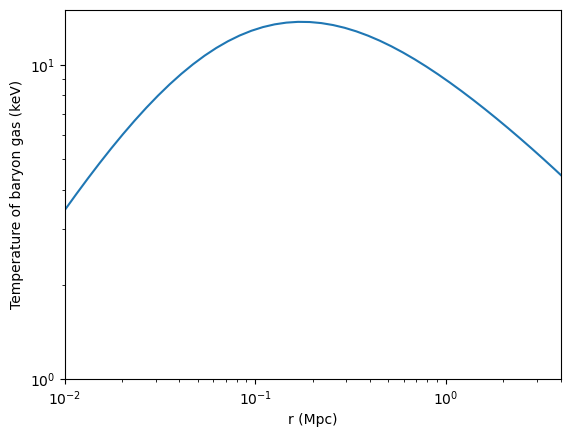

In [99]:
plt.loglog(rs, T_g(rs.value, 1*u.Mpc, 6*1e14*u.Msun, 0).to(u.keV))
plt.xlabel('r (Mpc)')
plt.ylabel('Temperature of baryon gas (keV)')
plt.ylim(1, 15)
plt.xlim(0.01, 4)

In [59]:
#plt.loglog(rs, dT_dr(rs, R500, M500, z))
#plt.xlabel('r (Mpc)')
#plt.ylabel('dT/dr (GeV/Mpc)')

In [60]:
# TODO: think about if the way i made this makes sense
plt.plot(rs, np.gradient(Pg(rs/R500, z, M500).to(u.erg*u.cm**-3), T_g(rs.value, R500, M500, z)))
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r (Mpc)')
plt.ylabel('dP/dT (erg/(cm^3*GeV))')

NameError: name 'dP_dr' is not defined